In [1]:
import math
import torch
import gpytorch
import os
import numpy as np
from matplotlib import pyplot as plt

from numpy import genfromtxt

from matplotlib import style
style.use('seaborn-white')

gpytorch.settings.max_cg_iterations(2000)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
my_data = genfromtxt('../../../Data/noisyCase/noisyData.csv', delimiter=',')
theta_sim = my_data[:,0]
theta_d_sim = my_data[:,1]
x_d_sim = my_data[:,3]
forceIn = my_data[:,4]
theta_dd_sim = my_data[:,5]
x_dd_sim = my_data[:,6]

# Training 

In [3]:
st_Traj = 0
en_Traj = 8000 # 2307 # 9405

# Training Input (Standardized)
theta_sim_mean = theta_sim[st_Traj:en_Traj].mean()
theta_sim_stdev = theta_sim[st_Traj:en_Traj].std()

theta_d_sim_mean = theta_d_sim[st_Traj:en_Traj].mean()
theta_d_sim_stdev = theta_d_sim[st_Traj:en_Traj].std()

x_d_sim_mean = x_d_sim[st_Traj:en_Traj].mean()
x_d_sim_stdev = x_d_sim[st_Traj:en_Traj].std()

forceIn_mean = forceIn[st_Traj:en_Traj].mean()
forceIn_stdev = forceIn[st_Traj:en_Traj].std()  

# Training Output (Standardized)
theta_dd_sim_mean = theta_dd_sim[st_Traj:en_Traj].mean()
theta_dd_sim_stdev = theta_dd_sim[st_Traj:en_Traj].std()  

x_dd_sim_mean = x_dd_sim[st_Traj:en_Traj].mean()
x_dd_sim_stdev = x_dd_sim[st_Traj:en_Traj].std() 

X_train = np.stack(((theta_sim[st_Traj:en_Traj]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[st_Traj:en_Traj]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[st_Traj:en_Traj]-x_d_sim_mean)/x_d_sim_stdev,(forceIn[st_Traj:en_Traj]-forceIn_mean)/forceIn_stdev), axis=1)

Y_train_theta = ((theta_dd_sim[st_Traj:en_Traj]-theta_dd_sim_mean)/theta_dd_sim_stdev)  # RMSE(A)
Y_train_x = ((x_dd_sim[st_Traj:en_Traj]-x_dd_sim_mean)/x_dd_sim_stdev)  # RMSE(V)

# Testing Output (Standardized)

Y_test_theta = ((theta_dd_sim[en_Traj:]-theta_dd_sim_mean)/theta_dd_sim_stdev)  # RMSE(A)
Y_test_x = ((x_dd_sim[en_Traj:]-x_dd_sim_mean)/x_dd_sim_stdev)  # RMSE(V)

X_prior = np.stack(((theta_sim-theta_sim_mean)/theta_sim_stdev,(theta_d_sim-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim-x_d_sim_mean)/x_d_sim_stdev,(forceIn-forceIn_mean)/forceIn_stdev), axis=1) # Prior

In [4]:
# Numpy to tensors 
X_train = torch.from_numpy(X_train).float()
Y_train_theta = torch.from_numpy(Y_train_theta).float()
Y_train_x = torch.from_numpy(Y_train_x).float()
X_prior = torch.from_numpy(X_prior).float()

# Putting tensors on GPU
X_train = X_train.cuda()
Y_train_theta = Y_train_theta.cuda()
Y_train_x = Y_train_x.cuda()
X_prior = X_prior.cuda()

# GPyTorch

In [5]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel(ard_num_dims=4))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model (setting a lower bound on the noise so it does not go to zero)
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_prior=gpytorch.priors.SmoothedBoxPrior(0.15, 1.5, sigma=0.001))
model_th = ExactGPModel(X_train, Y_train_theta, likelihood)
model_x = ExactGPModel(X_train, Y_train_x, likelihood)
# putting on GPU
model_x = model_x.cuda()
model_th = model_th.cuda()
likelihood = likelihood.cuda()

In [6]:
# Find optimal model hyperparameters
training_iter = 300

model_th.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model_th.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_th)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model_th(X_train)
    # Calc loss and backprop gradients
    loss = -mll(output, Y_train_theta)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f  noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model_th.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/300 - Loss: 0.792  noise: 0.693
Iter 2/300 - Loss: 0.787  noise: 0.688
Iter 3/300 - Loss: 0.783  noise: 0.683
Iter 4/300 - Loss: 0.778  noise: 0.678
Iter 5/300 - Loss: 0.774  noise: 0.673
Iter 6/300 - Loss: 0.770  noise: 0.669
Iter 7/300 - Loss: 0.766  noise: 0.664
Iter 8/300 - Loss: 0.761  noise: 0.659
Iter 9/300 - Loss: 0.757  noise: 0.654
Iter 10/300 - Loss: 0.754  noise: 0.649
Iter 11/300 - Loss: 0.749  noise: 0.644
Iter 12/300 - Loss: 0.746  noise: 0.640
Iter 13/300 - Loss: 0.740  noise: 0.635
Iter 14/300 - Loss: 0.737  noise: 0.630
Iter 15/300 - Loss: 0.733  noise: 0.626
Iter 16/300 - Loss: 0.729  noise: 0.621
Iter 17/300 - Loss: 0.724  noise: 0.616
Iter 18/300 - Loss: 0.720  noise: 0.612
Iter 19/300 - Loss: 0.716  noise: 0.607
Iter 20/300 - Loss: 0.712  noise: 0.603
Iter 21/300 - Loss: 0.708  noise: 0.598
Iter 22/300 - Loss: 0.703  noise: 0.593
Iter 23/300 - Loss: 0.700  noise: 0.589
Iter 24/300 - Loss: 0.696  noise: 0.585
Iter 25/300 - Loss: 0.690  noise: 0.580
Iter 26/3

In [7]:
# Find optimal model hyperparameters
training_iter = 300

model_x.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model_x.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_x)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model_x(X_train)
    # Calc loss and backprop gradients
    loss = -mll(output, Y_train_x)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f  noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model_x.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/300 - Loss: -0.045  noise: 0.114
Iter 2/300 - Loss: -0.047  noise: 0.115
Iter 3/300 - Loss: -0.048  noise: 0.116
Iter 4/300 - Loss: -0.049  noise: 0.117
Iter 5/300 - Loss: -0.045  noise: 0.118
Iter 6/300 - Loss: -0.048  noise: 0.118
Iter 7/300 - Loss: -0.047  noise: 0.118
Iter 8/300 - Loss: -0.049  noise: 0.118
Iter 9/300 - Loss: -0.047  noise: 0.118
Iter 10/300 - Loss: -0.051  noise: 0.117
Iter 11/300 - Loss: -0.051  noise: 0.117
Iter 12/300 - Loss: -0.050  noise: 0.116
Iter 13/300 - Loss: -0.054  noise: 0.116
Iter 14/300 - Loss: -0.052  noise: 0.116
Iter 15/300 - Loss: -0.052  noise: 0.115
Iter 16/300 - Loss: -0.052  noise: 0.115
Iter 17/300 - Loss: -0.052  noise: 0.115
Iter 18/300 - Loss: -0.053  noise: 0.116
Iter 19/300 - Loss: -0.052  noise: 0.116
Iter 20/300 - Loss: -0.054  noise: 0.116
Iter 21/300 - Loss: -0.053  noise: 0.116
Iter 22/300 - Loss: -0.054  noise: 0.117
Iter 23/300 - Loss: -0.055  noise: 0.117
Iter 24/300 - Loss: -0.056  noise: 0.117
Iter 25/300 - Loss: -0.05

In [8]:
# save models 
torch.save(model_th.state_dict(), '../../learnedModels/noisyCase/th_RatQuad_gpytorch')
torch.save(model_x.state_dict(), '../../learnedModels/noisyCase/x_RatQuad_gpytorch')

In [9]:
#gpytorch.settings.max_cg_iterations(2000)

# Get into evaluation (predictive posterior) mode
model_th.load_state_dict(torch.load('../../learnedModels/noisyCase/th_RatQuad_gpytorch'))

model_th.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred_th = likelihood(model_th(X_prior))

In [10]:
# Get into evaluation (predictive posterior) mode
model_x.load_state_dict(torch.load('../../learnedModels/noisyCase/x_RatQuad_gpytorch'))

model_x.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred_x = likelihood(model_x(X_prior))

In [11]:
# Putting back on CPU
X_train = X_train.cpu()
Y_train_theta = Y_train_theta.cpu()
Y_train_x = Y_train_x.cpu()
X_prior = X_prior.cpu()

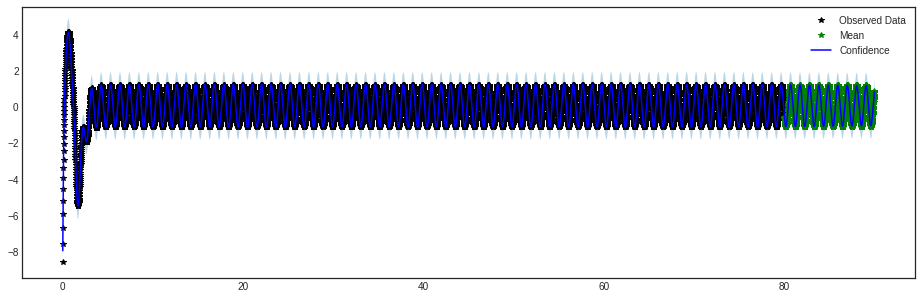

In [16]:
star_Traj = 0
mids_Traj = 8000
ends_Traj = 9000

dt = 0.01
noOfSteps = 12000
timeSteps = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False) # for plotting 

with torch.no_grad():
    # Initialize plot
    fig, ax = plt.subplots(1)

    fig.set_figheight(5)
    fig.set_figwidth(16)

    # Get upper and lower confidence bounds
    lower, upper = observed_pred_th.confidence_region()
    lower = lower.cpu()
    upper = upper.cpu()
    mean = observed_pred_th.mean
    mean = mean.cpu()
    ax.plot(timeSteps[star_Traj:mids_Traj], Y_train_theta[star_Traj:], 'k*')
    ax.plot(timeSteps[mids_Traj:ends_Traj], Y_test_theta[:ends_Traj-mids_Traj], 'g*')
    ax.plot(timeSteps[star_Traj:ends_Traj], mean.numpy()[star_Traj:ends_Traj], 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(timeSteps[star_Traj:ends_Traj], lower.numpy()[star_Traj:ends_Traj], upper.numpy()[star_Traj:ends_Traj], alpha=0.3)
    #ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

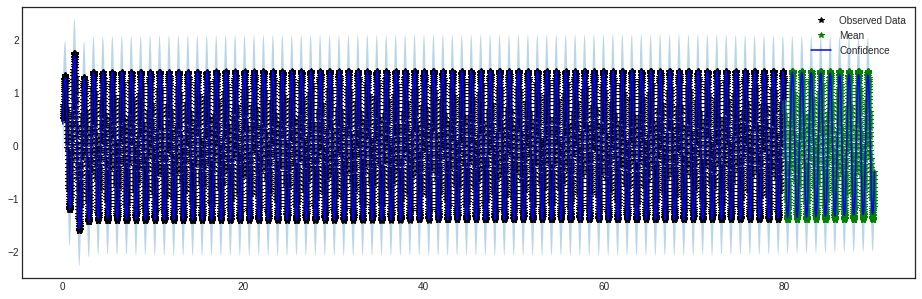

In [17]:
with torch.no_grad():
    # Initialize plot
    fig, ax = plt.subplots(1)

    fig.set_figheight(5)
    fig.set_figwidth(16)

    # Get upper and lower confidence bounds
    lower, upper = observed_pred_x.confidence_region()
    lower = lower.cpu()
    upper = upper.cpu()
    mean = observed_pred_x.mean
    mean = mean.cpu()
    ax.plot(timeSteps[star_Traj:mids_Traj], Y_train_x[star_Traj:], 'k*')
    ax.plot(timeSteps[mids_Traj:ends_Traj], Y_test_x[:ends_Traj-mids_Traj], 'g*')
    ax.plot(timeSteps[star_Traj:ends_Traj], mean.numpy()[star_Traj:ends_Traj], 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(timeSteps[star_Traj:ends_Traj], lower.numpy()[star_Traj:ends_Traj], upper.numpy()[star_Traj:ends_Traj], alpha=0.3)
    #ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

# RMSE

In [ ]:
model_th.load_state_dict(torch.load('th_RatQuad_gpytorch'))
model_x.load_state_dict(torch.load('x_RatQuad_gpytorch'))

In [86]:
trunc_st = 7950
trunc_en = 8800

X_prior = np.stack(((theta_sim[trunc_st:trunc_en]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[trunc_st:trunc_en]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[trunc_st:trunc_en]-x_d_sim_mean)/x_d_sim_stdev,(forceIn[trunc_st:trunc_en]-forceIn_mean)/forceIn_stdev), axis=1)
#X_prior = np.stack(((theta_sim[:-1]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[:-1]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[:-1]-x_d_sim_mean)/x_d_sim_stdev,(forceIn-forceIn_mean)/forceIn_stdev), axis=1) # Prior

# Putting back on CPU
X_prior = torch.from_numpy(X_prior).float()
X_prior = X_prior.cuda()

In [87]:
mu_th_dd = np.zeros(X_prior.shape[0])
lower_th, upper_th = np.zeros(X_prior.shape[0]), np.zeros(X_prior.shape[0])
gp_th_d = np.zeros(X_prior.shape[0])
gp_th = np.zeros(X_prior.shape[0])

mu_x_dd = np.zeros(X_prior.shape[0])
lower_x, upper_x = np.zeros(X_prior.shape[0]), np.zeros(X_prior.shape[0])
gp_x_d = np.zeros(X_prior.shape[0])
gp_x = np.zeros(X_prior.shape[0])

mu_th_dd[0] =  theta_dd_sim[trunc_st]
gp_th_d[0] = theta_d_sim[trunc_st]
gp_th[0] = theta_sim[trunc_st]
mu_x_dd[0] = x_dd_sim[trunc_st]
gp_x_d[0] = x_d_sim[trunc_st]
gp_x[0] = x_sim[trunc_st]

for k in range(X_prior.shape[0]):
    if k != X_prior.shape[0]-1:
        model_th.eval()
        model_x.eval()
        likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred_th = likelihood(model_th(X_prior[k,:].reshape(1,-1)))
            observed_pred_x = likelihood(model_x(X_prior[k,:].reshape(1,-1)))
            mu_th_dd[k+1] = observed_pred_th.mean
            mu_x_dd[k+1] = observed_pred_x.mean
            lower_th[k+1], upper_th[k+1] = observed_pred_th.confidence_region()
            lower_x[k+1], upper_x[k+1] = observed_pred_x.confidence_region()
        unstand_acc = mu_th_dd[k+1]*theta_dd_sim_stdev + theta_dd_sim_mean
        gp_th_d[k+1] = gp_th_d[k]+(unstand_acc)*(dt)
        X_prior[k+1,1] = (gp_th_d[k+1]-theta_d_sim_mean) / theta_d_sim_stdev
        gp_th[k+1] = gp_th[k] + (gp_th_d[k+1] + gp_th_d[k])*(dt) / 2 #+ (0.5)*(mu_s[k])*(dt**2)
        X_prior[k+1,0] = (gp_th[k+1]-theta_sim_mean) / theta_sim_stdev
        unstand_x = mu_x_dd[k+1]*x_dd_sim_stdev + x_dd_sim_mean
        gp_x_d[k+1] = gp_x_d[k]+(unstand_x)*(dt)
        X_prior[k+1,2] = (gp_x_d[k+1]-x_d_sim_mean) / x_d_sim_stdev
        gp_x[k+1] = gp_x[k] + (gp_x_d[k+1] + gp_x_d[k])*(dt) / 2 #+ (0.5)*(mu_s[k])*(dt**2)

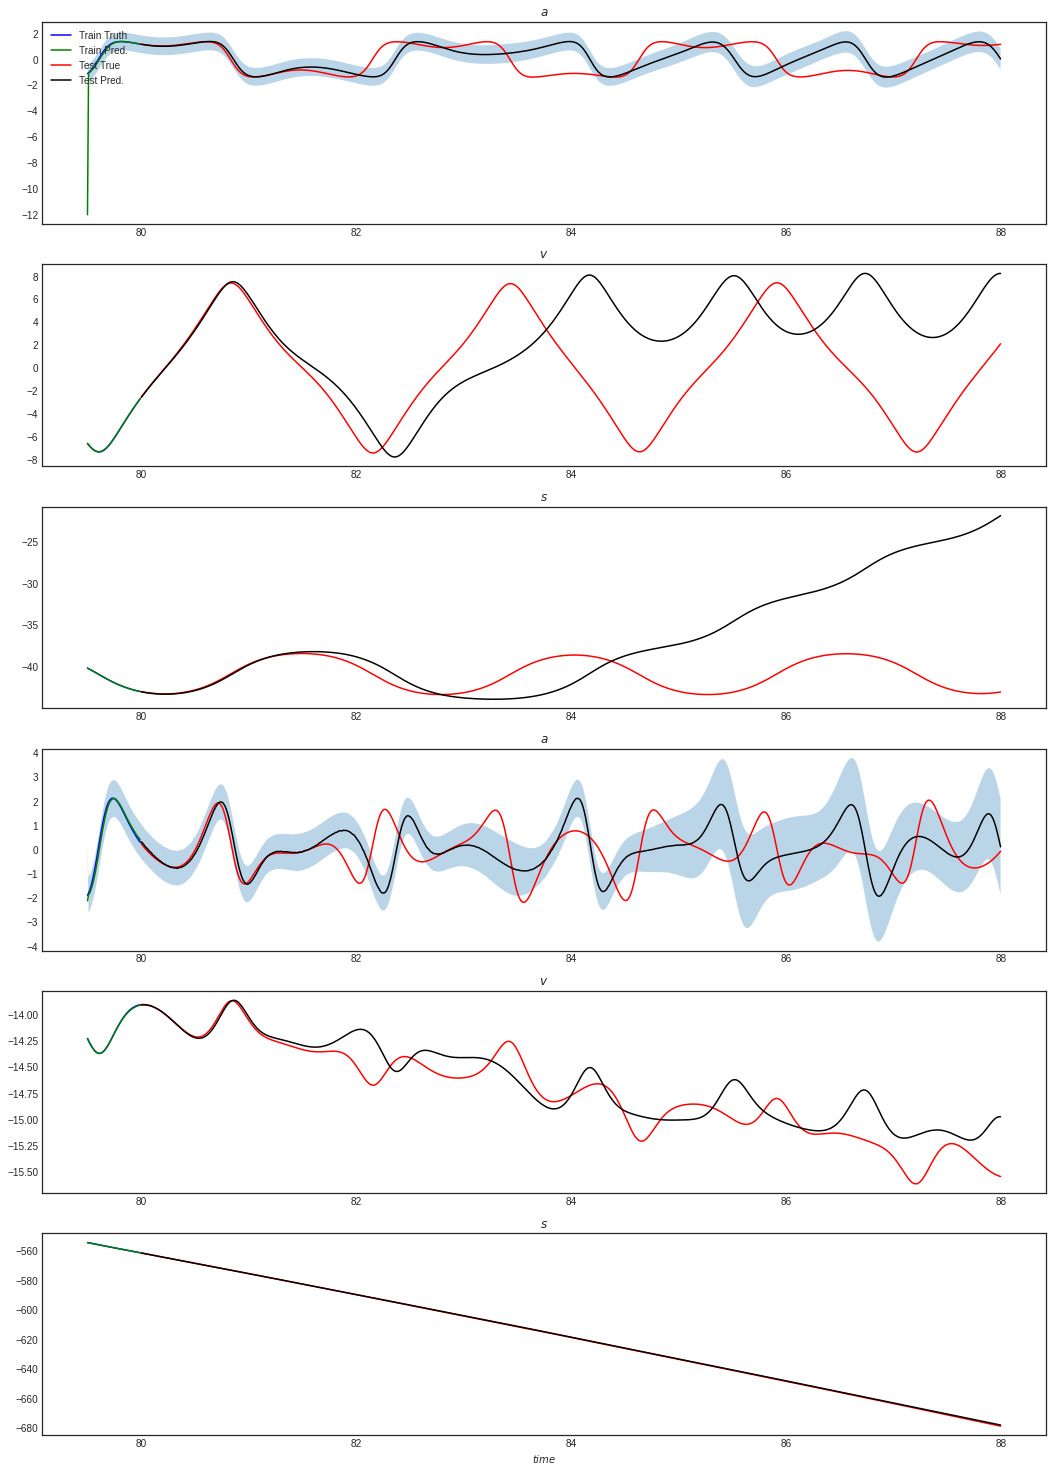

In [88]:
# Plotting 
train_test_split = 8000 # define it above later on 

st_Trajec = trunc_st
mid_Trajec = train_test_split
en_Trajec = trunc_en

# For predictions
mid_pred = train_test_split - trunc_st 

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6) 

fig.set_figheight(26)
fig.set_figwidth(18)

ax1.fill_between(timeSteps[st_Trajec:en_Trajec], lower_th, upper_th, alpha=0.3)
b1, = ax1.plot(timeSteps[st_Trajec:mid_Trajec], Y_train_theta[st_Trajec:mid_Trajec], "b")
g1, = ax1.plot(timeSteps[st_Trajec:mid_Trajec], mu_th_dd[:mid_pred], "g")
r1, = ax1.plot(timeSteps[mid_Trajec:en_Trajec], Y_test_theta[:en_Trajec-mid_Trajec], "r")
k1, = ax1.plot(timeSteps[mid_Trajec:en_Trajec], mu_th_dd[mid_pred:], "k")
ax1.set_title('$a$')

ax2.plot(timeSteps[st_Trajec:mid_Trajec], theta_d_sim[st_Trajec:mid_Trajec], "b")
ax2.plot(timeSteps[st_Trajec:mid_Trajec], gp_th_d[:mid_pred], "g")
ax2.plot(timeSteps[mid_Trajec:en_Trajec], theta_d_sim[mid_Trajec:en_Trajec], "r")
ax2.plot(timeSteps[mid_Trajec:en_Trajec], gp_th_d[mid_pred:], "k")
ax2.set_title('$v$')

ax3.plot(timeSteps[st_Trajec:mid_Trajec], theta_sim[st_Trajec:mid_Trajec], "b")
ax3.plot(timeSteps[st_Trajec:mid_Trajec], gp_th[:mid_pred], "g")
ax3.plot(timeSteps[mid_Trajec:en_Trajec], theta_sim[mid_Trajec:en_Trajec], "r")
ax3.plot(timeSteps[mid_Trajec:en_Trajec], gp_th[mid_pred:], "k")
ax3.set_title('$s$')

ax4.fill_between(timeSteps[st_Trajec:en_Trajec], lower_x, upper_x, alpha=0.3)
ax4.plot(timeSteps[st_Trajec:mid_Trajec], Y_train_x[st_Trajec:], "b")
ax4.plot(timeSteps[st_Trajec:mid_Trajec], mu_x_dd[:mid_pred], "g")
ax4.plot(timeSteps[mid_Trajec:en_Trajec], Y_test_x[:en_Trajec-mid_Trajec], "r")
ax4.plot(timeSteps[mid_Trajec:en_Trajec], mu_x_dd[mid_pred:], "k")
ax4.set_title('$a$')

ax5.plot(timeSteps[st_Trajec:mid_Trajec], x_d_sim[st_Trajec:mid_Trajec], "b")
ax5.plot(timeSteps[st_Trajec:mid_Trajec], gp_x_d[:mid_pred], "g")
ax5.plot(timeSteps[mid_Trajec:en_Trajec], x_d_sim[mid_Trajec:en_Trajec], "r")
ax5.plot(timeSteps[mid_Trajec:en_Trajec], gp_x_d[mid_pred:], "k")
ax5.set_title('$v$')

ax6.plot(timeSteps[st_Trajec:mid_Trajec], x_sim[st_Trajec:mid_Trajec], "b")
ax6.plot(timeSteps[st_Trajec:mid_Trajec], gp_x[:mid_pred], "g")
ax6.plot(timeSteps[mid_Trajec:en_Trajec], x_sim[mid_Trajec:en_Trajec], "r")
ax6.plot(timeSteps[mid_Trajec:en_Trajec], gp_x[mid_pred:], "k")
ax6.set_title('$s$')

ax1.legend((b1, g1, r1, k1), ('Train Truth', 'Train Pred.', 'Test True', 'Test Pred.'), loc='upper left', shadow=False)
plt.xlabel("$time$")
#plt.savefig('GP_Exp_Stand_JIANG(A).png')
plt.show()